In [0]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm_

In [0]:
# set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
class NewsPopularityDataset(Dataset):
  
  def __init__(self, filename):
    self.dataset = pd.read_csv(filename, delimiter=',')
    self.dataset = self.dataset.values
    self.dataset = torch.tensor(self.dataset)
    
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    return self.dataset[idx, :-1].float(), self.dataset[idx, -1].long()


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
train_filename = "gdrive/My Drive/Colab Notebooks/OnlineNewsPopularity/train_data.csv"
val_filename = "gdrive/My Drive/Colab Notebooks/OnlineNewsPopularity/test_data.csv"

In [0]:
train_dataset = NewsPopularityDataset(train_filename)
val_dataset = NewsPopularityDataset(val_filename)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [8]:
next(iter(train_loader))

[tensor([[2.1370e+03, 6.9500e+02, 8.0000e+00,  ..., 5.0000e-01, 0.0000e+00,
          5.3800e+02],
         [2.5184e+04, 2.3900e+02, 1.2000e+01,  ..., 3.5714e-02, 2.8571e-01,
          2.5000e+03],
         [1.3050e+03, 7.0900e+02, 1.0000e+01,  ..., 5.0000e-01, 5.0000e-01,
          2.8000e+03],
         ...,
         [2.5815e+04, 2.2700e+02, 1.1000e+01,  ..., 3.2500e-01, 0.0000e+00,
          1.5000e+03],
         [1.4913e+04, 4.4300e+02, 9.0000e+00,  ..., 5.0000e-01, 0.0000e+00,
          8.2900e+02],
         [3.8708e+04, 2.7000e+01, 1.1000e+01,  ..., 1.0000e-01, 5.0000e-02,
          9.3600e+02]]),
 tensor([1, 2, 1, 3, 1, 1, 2, 2, 5, 1, 3, 5, 1, 5, 1, 2, 3, 0, 4, 0, 1, 0, 2, 3,
         1, 3, 1, 3, 1, 0, 1, 0, 1, 2, 3, 3, 5, 1, 0, 3, 0, 3, 2, 4, 3, 0, 2, 3,
         5, 0, 2, 2, 3, 0, 3, 2, 1, 3, 3, 1, 2, 0, 1, 4])]

In [0]:
# define model

class Model(nn.Module):
  def __init__(self, num_features, num_classes):
    super(Model, self).__init__()
    
    self.fc1 = nn.Linear(num_features, 64)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(64, 128)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(128, 256)
    self.relu3 = nn.ReLU()
    self.fc4 = nn.Linear(256, 256)
    self.relu4 = nn.ReLU()
    self.fc5 = nn.Linear(256, 128)
    self.relu5 = nn.ReLU()
    self.fc6 = nn.Linear(128, 64)
    self.relu6 = nn.ReLU()
    self.fc7 = nn.Linear(64, num_classes)
    
  def forward(self, x):
    x = self.relu1(self.fc1(x))
    x = self.relu2(self.fc2(x))
    x = self.relu3(self.fc3(x))
    x = self.relu4(self.fc4(x))
    x = self.relu5(self.fc5(x))
    x = self.relu6(self.fc6(x))
    x = self.fc7(x)
    return x
  
  

In [0]:
# define train method

def train(data_loader, model, optimizer, criterion, curr_epoch, tot_epochs, device):
  
  # set model to training mode
  model.train()
  
  tot_train_loss = 0.0
  
  train_meter = tqdm(
      data_loader, unit=' batches',
      desc=f'[Epoch {curr_epoch}/{tot_epochs}]',
      leave=False
  )
  
  for batch_idx, (sample, label) in enumerate(train_meter):
    
    # transfer to device
    sample, label = sample.to(device), label.to(device)
    
    # zero out gradients
    optimizer.zero_grad()
    
    # forward pass
    out = model(sample)
    
    # compute loss
    loss = criterion(out, label)
    
    # backward
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    # update tqdm meter
    train_meter.set_postfix(train_loss=f'{loss.item():0.4f}')
    train_meter.update()
    
    # add to total train loss
    tot_train_loss = tot_train_loss + loss.item()
    
  av_train_loss = tot_train_loss / (batch_idx + 1)
  return av_train_loss

In [0]:
# define validation method

def validate(data_loader, model, criterion, device):
  
  # set model to eval mode
  model.eval()
  
  tot_val_loss = 0.0
  corrects = 0
  total = 0
  
  val_meter = tqdm(
      data_loader, unit=' batches',
      desc='val',
      leave=False
  )
  
  with torch.no_grad():
    for batch_idx, (sample, label) in enumerate(val_meter):

      # transfer to device
      sample, label = sample.to(device), label.to(device)

      # forward pass
      out = model(sample)

      # compute loss
      loss = criterion(out, label)
      
      # compute the prediction
      max_value, pred = torch.max(out, dim=-1)
      
      # compute number of correct predictions
#       print('before update', corrects, (pred == label).sum().item())
      corrects += (pred == label).sum().item()
#       print('after update', corrects, (pred == label).sum().item())
      # update total samples
      total = total + len(label)

      # update tqdm meter
      val_meter.set_postfix(val_loss=f'{loss.item():0.4f}')
      val_meter.update()

      # add to total val loss
      tot_val_loss = tot_val_loss + loss.item()

  av_val_loss = tot_val_loss / (batch_idx + 1)
#   print(corrects, total)
  accuracy = corrects / total
  return av_val_loss, accuracy

In [25]:
# specify learning rate
learning_rate = 0.001

# create model object
model = Model(53, 7)

# transfer model to device
model = model.to(device)

# print model
print(89 * '-' + '\n', model, '\n' + 89 * '-')

# print number of parameters
print('number of parameters:', sum(m.numel() for m in model.parameters()))
print(89 * '-')

# create optimizer
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, model.parameters()),
    lr=learning_rate
)

# specify criterion
criterion = nn.CrossEntropyLoss()

-----------------------------------------------------------------------------------------
 Model(
  (fc1): Linear(in_features=53, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (relu6): ReLU()
  (fc7): Linear(in_features=64, out_features=7, bias=True)
) 
-----------------------------------------------------------------------------------------
number of parameters: 152199
-----------------------------------------------------------------------------------------


In [52]:
# specify max number of epochs
num_epochs = 100

train_losses, val_losses, accs = [], [], []

for epoch in range(1, num_epochs + 1):
  train_loss = train(train_loader, model, optimizer, criterion, epoch, num_epochs, device)
  val_loss, accuracy = validate(val_loader, model, criterion, device)
  
  # check for early stopping
  if all(val_loss > loss for loss in val_losses[-3:]) and len(val_losses) > 2: 
    print('stopping early')
    break
  
  # save losses
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  accs.append(accuracy)
  
  # print losses and accuracies
  tqdm_.write(f'[Epoch {epoch}/{num_epochs}] \
             train loss: {train_loss:0.4f}, \
             val loss: {val_loss:0.4f}, \
             accuracy: {accuracy * 100:0.2f} %')

[Epoch 1/100]              train loss: 1.8638,              val loss: 2.0403,              accuracy: 14.36 %


[Epoch 2/100]              train loss: 1.8639,              val loss: 2.0399,              accuracy: 14.36 %


[Epoch 3/100]              train loss: 1.8639,              val loss: 2.0395,              accuracy: 14.36 %


[Epoch 4/100]              train loss: 1.8638,              val loss: 2.0387,              accuracy: 14.36 %


stopping early


In [0]:
# plot losses and accuracies

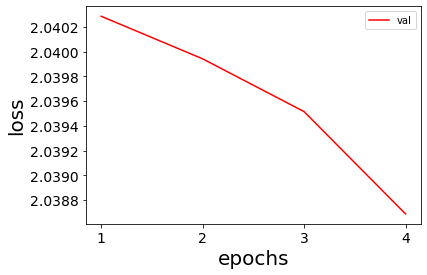

In [54]:
%matplotlib inline
# plt.plot(train_losses, label='train')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='val', c='r')
plt.legend()
plt.xlabel('epochs', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xticks(range(1, len(val_losses) + 1), fontsize=14)
plt.yticks(fontsize=14)
plt.show()